In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import time
import copy

In [2]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device


kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

### 1. Load Dataset

In [3]:


torch.manual_seed(1)
batch_size = 128

mnist = torchvision.datasets.MNIST('./var', download=True)
train_transform = transforms.Compose(
                    [
                    
#                   transforms.RandomRotation(5),
                    transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.1310], std=[0.3085]),
                    
                    ])
test_transform=  transforms.Compose(
                    [
                   
                    torchvision.transforms.ToTensor(),
                    transforms.Normalize(mean=[0.1310], std=[0.3085]),
                    ])

train = torchvision.datasets.MNIST('./var', train=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test = torchvision.datasets.MNIST('./var', train=False, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test, batch_size=len(test), shuffle=True)



### 2. Visualize loaded data

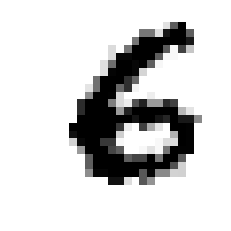

In [4]:
for inputs, outputs in train_loader:
    #slice out one channel
    image = inputs[0][0]
    plt.imshow(image.numpy(), cmap=plt.get_cmap('binary'))
    plt.axis('off')
    break

### 3. Train CNN

In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.069)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.069)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.069)
        )
       
        self.fc = nn.Sequential(
            
            nn.Linear(128, 10)
        )

            
        
     
                
        
    def forward(self, x):
        x = self.conv1(x)
        self.after_conv1 = x
        x = self.conv2(x)
        self.after_conv2 = x
        
        x = self.conv3(x)
        self.after_conv3=x
        
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
       # x=F.adaptive_avg_pool2d(x,(10,10))
        
        x = F.log_softmax(x, dim=1)
        return x

In [6]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    running_loss = 0
    accuracy=0
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (images, labels) in enumerate(pbar):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        log_ps = model(images)
        
        ps = torch.exp(log_ps)                
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))

        loss = loss_function(log_ps, labels)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
       # record training loss and error, then evaluate using validation data
    train_losses.append(running_loss/len(train_loader))
    train_accu.append(accuracy/len(train_loader))    

    

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    accuracy=0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            log_ps = model(images)
            test_loss += loss_function(log_ps, labels)  # sum up batch loss
            pred = log_ps.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))     



          

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss/len(test_loader))
    test_accu.append(accuracy/len(test_loader))  

 
    

    

def display_train(model,device,train_loader):

  for images, labels in train_loader:
    # multi image figure
    figure = plt.figure()
    # the original image
    image = images[0][0]
    
    figure.add_subplot(3, 6, 1)
    plt.imshow(image.numpy(), cmap=plt.get_cmap('binary'))
    output = model(image)
    # remember we have a batch in the model -- and this
    # has a gradient, so we'll need it detached to get numpy format
    filter_one = model.after_conv1[0].detach()
    for i in range(3):
        figure.add_subplot(3, 6, 6 + 1 + i)
        plt.imshow(filter_one[i].cpu().numpy(), cmap=plt.get_cmap('binary'))
    
    filter_two = model.after_conv2[0].detach()
    for i in range(6):
        figure.add_subplot(3, 6, 12 + 1 + i)
        plt.imshow(filter_two[i].cpu().numpy(), cmap=plt.get_cmap('binary'))
    plt.show()

    break






In [7]:

model = Model().to(device)
optimizer = optim.Adam(model.parameters(),lr=1e-4)
loss_function = nn.NLLLoss()
epochs = 19
train_losses, test_losses = [], []
train_accu, test_accu = [], []
start_time = time.time()
early_stop_counter = 10   # stop when the validation loss does not improve for 10 iterations to prevent overfitting
counter = 0
best_test_loss = float('Inf')


summary(model, input_size=(1, 28, 28))

for epoch in range(epochs):
    epoch_start_time = time.time()
   
    # training step
    train(model, device, train_loader, optimizer, epoch) 


    test(model, device, test_loader) 
    print("Epoch: {}/{}.. ".format(epoch+1, epochs),
      "Time: {:.2f}s..".format(time.time()-epoch_start_time),
      "Training Loss: {:.3f}.. ".format(train_losses[-1]),
      "Training Accu: {:.3f}.. ".format(train_accu[-1]),
      "Val Loss: {:.3f}.. ".format(test_losses[-1]),
      "Val Accu: {:.3f}".format(test_accu[-1]))
    
    if test_losses[-1] < best_test_loss:
        best_val_loss = test_losses[-1]
        counter=0
        best_model_wts = copy.deepcopy(model.state_dict())
    else:
        counter+=1
        print('Validation loss has not improved since: {:.3f}..'.format(best_val_loss), 'Count: ', str(counter))
        if counter >= early_stop_counter:
            print('Early Stopping Now!!!!')
            model.load_state_dict(best_model_wts)
            break   







loss=2.6776821613311768 batch_id=1:   0%|          | 2/469 [00:00<00:37, 12.58it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
       BatchNorm2d-3           [-1, 32, 28, 28]              64
            Conv2d-4           [-1, 32, 28, 28]           9,248
              ReLU-5           [-1, 32, 28, 28]               0
       BatchNorm2d-6           [-1, 32, 28, 28]              64
            Conv2d-7           [-1, 32, 14, 14]           9,248
              ReLU-8           [-1, 32, 14, 14]               0
       BatchNorm2d-9           [-1, 32, 14, 14]              64
        MaxPool2d-10             [-1, 32, 7, 7]               0
          Dropout-11             [-1, 32, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          18,496
             ReLU-13             [-1, 64, 7, 7]               0
      BatchNorm2d-14             [-1, 6

loss=0.3506840467453003 batch_id=1:   0%|          | 2/469 [00:00<00:33, 14.11it/s]

Epoch: 1/19..  Time: 38.15s.. Training Loss: 0.000..  Training Accu: 0.717..  Val Loss: 0.000..  Val Accu: 0.975


loss=0.14517654478549957 batch_id=1:   0%|          | 2/469 [00:00<00:36, 12.94it/s]

Epoch: 2/19..  Time: 38.10s.. Training Loss: 0.000..  Training Accu: 0.942..  Val Loss: 0.000..  Val Accu: 0.987


loss=0.11933135241270065 batch_id=1:   0%|          | 2/469 [00:00<00:34, 13.59it/s]

Epoch: 3/19..  Time: 37.99s.. Training Loss: 0.000..  Training Accu: 0.961..  Val Loss: 0.000..  Val Accu: 0.988


loss=0.03817378357052803 batch_id=1:   0%|          | 2/469 [00:00<00:34, 13.58it/s]

Epoch: 4/19..  Time: 38.29s.. Training Loss: 0.000..  Training Accu: 0.969..  Val Loss: 0.000..  Val Accu: 0.989


loss=0.058475952595472336 batch_id=1:   0%|          | 2/469 [00:00<00:33, 14.11it/s]

Epoch: 5/19..  Time: 38.32s.. Training Loss: 0.000..  Training Accu: 0.974..  Val Loss: 0.000..  Val Accu: 0.991


loss=0.1023772656917572 batch_id=1:   0%|          | 2/469 [00:00<00:36, 12.95it/s]

Epoch: 6/19..  Time: 38.19s.. Training Loss: 0.000..  Training Accu: 0.978..  Val Loss: 0.000..  Val Accu: 0.992


loss=0.059526365250349045 batch_id=1:   0%|          | 2/469 [00:00<00:33, 13.82it/s]

Epoch: 7/19..  Time: 38.24s.. Training Loss: 0.000..  Training Accu: 0.979..  Val Loss: 0.000..  Val Accu: 0.992


loss=0.05817505717277527 batch_id=1:   0%|          | 2/469 [00:00<00:33, 14.15it/s]

Epoch: 8/19..  Time: 38.63s.. Training Loss: 0.000..  Training Accu: 0.982..  Val Loss: 0.000..  Val Accu: 0.992


loss=0.11201724410057068 batch_id=1:   0%|          | 2/469 [00:00<00:33, 13.85it/s]

Epoch: 9/19..  Time: 37.54s.. Training Loss: 0.000..  Training Accu: 0.983..  Val Loss: 0.000..  Val Accu: 0.994


loss=0.10558625310659409 batch_id=1:   0%|          | 2/469 [00:00<00:32, 14.39it/s]

Epoch: 10/19..  Time: 37.90s.. Training Loss: 0.000..  Training Accu: 0.984..  Val Loss: 0.000..  Val Accu: 0.994


loss=0.022156501188874245 batch_id=1:   0%|          | 2/469 [00:00<00:36, 12.76it/s]

Epoch: 11/19..  Time: 37.82s.. Training Loss: 0.000..  Training Accu: 0.984..  Val Loss: 0.000..  Val Accu: 0.994


loss=0.07593748718500137 batch_id=1:   0%|          | 2/469 [00:00<00:32, 14.20it/s]

Epoch: 12/19..  Time: 37.67s.. Training Loss: 0.000..  Training Accu: 0.986..  Val Loss: 0.000..  Val Accu: 0.993


loss=0.02094746008515358 batch_id=1:   0%|          | 2/469 [00:00<00:33, 14.01it/s]

Epoch: 13/19..  Time: 37.42s.. Training Loss: 0.000..  Training Accu: 0.986..  Val Loss: 0.000..  Val Accu: 0.994


loss=0.025068581104278564 batch_id=1:   0%|          | 2/469 [00:00<00:32, 14.31it/s]

Epoch: 14/19..  Time: 37.88s.. Training Loss: 0.000..  Training Accu: 0.987..  Val Loss: 0.000..  Val Accu: 0.995


loss=0.020379073917865753 batch_id=1:   0%|          | 2/469 [00:00<00:33, 14.00it/s]

Epoch: 15/19..  Time: 37.44s.. Training Loss: 0.000..  Training Accu: 0.987..  Val Loss: 0.000..  Val Accu: 0.996


loss=0.03741325065493584 batch_id=1:   0%|          | 2/469 [00:00<00:34, 13.70it/s]

Epoch: 16/19..  Time: 37.62s.. Training Loss: 0.000..  Training Accu: 0.987..  Val Loss: 0.000..  Val Accu: 0.995


loss=0.040903039276599884 batch_id=1:   0%|          | 2/469 [00:00<00:32, 14.35it/s]

Epoch: 17/19..  Time: 37.53s.. Training Loss: 0.000..  Training Accu: 0.988..  Val Loss: 0.000..  Val Accu: 0.996


loss=0.034546270966529846 batch_id=1:   0%|          | 2/469 [00:00<00:34, 13.39it/s]

Epoch: 18/19..  Time: 37.57s.. Training Loss: 0.000..  Training Accu: 0.988..  Val Loss: 0.000..  Val Accu: 0.995


loss=0.09299352765083313 batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.71it/s]


Epoch: 19/19..  Time: 38.25s.. Training Loss: 0.000..  Training Accu: 0.989..  Val Loss: 0.000..  Val Accu: 0.996


#### 4. Visualize training

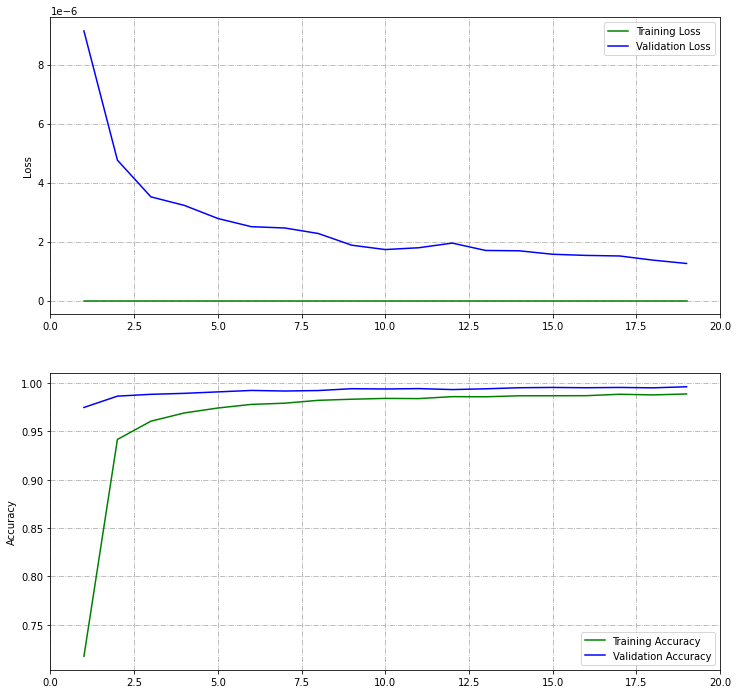

In [9]:
# plot training history
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
ax = plt.gca()
ax.set_xlim([0, epoch + 2])
plt.ylabel('Loss')
plt.plot(range(1, epoch + 2), train_losses[:epoch+1], 'g', label='Training Loss')
plt.plot(range(1, epoch + 2), test_losses[:epoch+1], 'b', label='Validation Loss')
ax.grid(linestyle='-.')
plt.legend()
plt.subplot(2,1,2)
ax = plt.gca()
ax.set_xlim([0, epoch+2])
plt.ylabel('Accuracy')
plt.plot(range(1, epoch + 2), train_accu[:epoch+1], 'g', label='Training Accuracy')
plt.plot(range(1, epoch + 2), test_accu[:epoch+1], 'b', label='Validation Accuracy')
ax.grid(linestyle='-.')
plt.legend()
plt.show()        